In [2]:
import json
import numpy as np
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense, Dropout, GRU, LSTM
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers
import tensorflow as tf
from sklearn.metrics import f1_score
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [80]:
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
data2 = load_data("Dataset2-AspectTermExtraction_train.json")

texts2 = [i['text'] for i in data2]
labels = [i['labels'] for i in data2]
words2 = [sentence.split() for sentence in texts2]

max_length = max([len(i) for i in words2])
max_length

78

In [81]:
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"  # Example: glove.6B.100d.txt
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words2:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)

# Vectorization of words
word_embeddings2 = []
for sentence in words2:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings2.append(sentence_embedding)

for sentence in word_embeddings2:
    sentence_length = len(sentence)
    if sentence_length < max_length: #max length of sentence = 78
        while len(sentence) < max_length:
            sentence.append(np.zeros(100))     

# padding to convert into (905, 70, 100)  from (905, variable_length, 70)           
for i in range(len(word_embeddings2)):
    word_embeddings2[i] = np.array(word_embeddings2[i])
word_embeddings2 = np.array(word_embeddings2)
print(word_embeddings2.shape) 


(906, 78, 100)


In [82]:
flat_labels = [label for sublist in labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels_idx = [[label2idx[label] for label in sublist] for sublist in labels]

# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]


def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels = convert_to_list(one_hot_labels)
labels_idx[0]

[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 2, 1]

In [83]:
for sentence in one_hot_labels:
    sentence_length = len(sentence)
    if sentence_length < 78: #max length of sentence = 78
        while len(sentence) < 78:
            sentence.append([0., 1., 0.])

one_hot_labels = np.array(one_hot_labels)
one_hot_labels.shape

(906, 78, 3)

5/5 [==============================] - 0s 17ms/step
Epoch 1: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 1: Training Accuracy: 0.9423909187316895, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 19ms/step
Epoch 2: Training Macro-F1-score: 0.40569273472630923, Validation Macro-F1-score: 0.3974860859935732
Epoch 2: Training Accuracy: 0.9741425514221191, Validation Accuracy: 0.9736990928649902
5/5 [==============================] - 0s 15ms/step
Epoch 3: Training Macro-F1-score: 0.4631389708625895, Validation Macro-F1-score: 0.4736500758113568
Epoch 3: Training Accuracy: 0.9744089245796204, Validation Accuracy: 0.9778469204902649
5/5 [==============================] - 0s 18ms/step
Epoch 4: Training Macro-F1-score: 0.498587752644241, Validation Macro-F1-score: 0.49127351260003965
Epoch 4: Training Accuracy: 0.9774059057235718, Validation Accuracy: 0.9780354499816895
5/5 [==============================] -

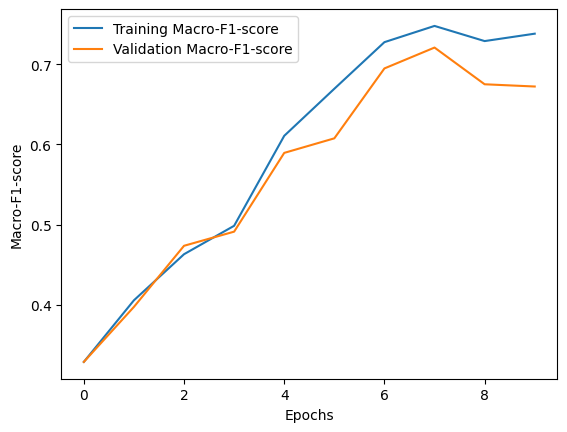

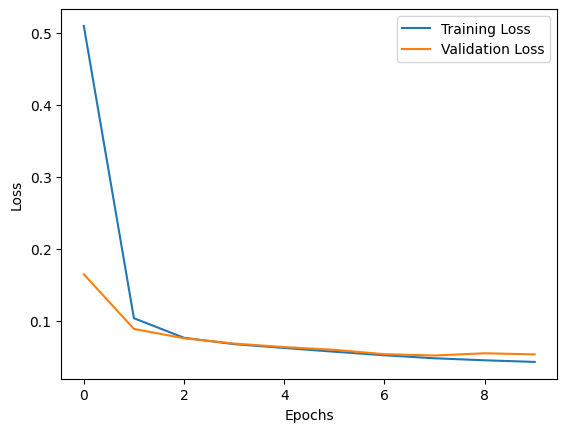

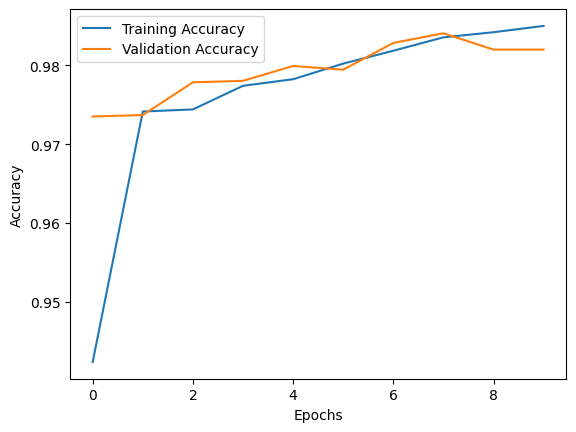

In [84]:
#SimpleRNN
X_train_padded = word_embeddings2  # Assuming padded word embeddings
y_train_padded = one_hot_labels           # Assuming padded labels

# Split into training and validation sets with stratified split
split = int(0.85 * len(X_train_padded))
X_train, X_val = X_train_padded[:split], X_train_padded[split:]
y_train, y_val = y_train_padded[:split], y_train_padded[split:]

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.SimpleRNN(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()

In [85]:
model.save('SimpleRNN-Dataset2-Glove.keras')

# GRU

5/5 [==============================] - 0s 8ms/step
Epoch 1: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3322418799632901
Epoch 1: Training Accuracy: 0.9420912265777588, Validation Accuracy: 0.9736047983169556
5/5 [==============================] - 0s 8ms/step
Epoch 2: Training Macro-F1-score: 0.3660880328934332, Validation Macro-F1-score: 0.3633801470325851
Epoch 2: Training Accuracy: 0.9738927483558655, Validation Accuracy: 0.9740761518478394
5/5 [==============================] - 0s 8ms/step
Epoch 3: Training Macro-F1-score: 0.5073877612291587, Validation Macro-F1-score: 0.4914808091581482
Epoch 3: Training Accuracy: 0.9740926027297974, Validation Accuracy: 0.9742646813392639
5/5 [==============================] - 0s 8ms/step
Epoch 4: Training Macro-F1-score: 0.5789239502772606, Validation Macro-F1-score: 0.5461424081317886
Epoch 4: Training Accuracy: 0.9768231511116028, Validation Accuracy: 0.9777526259422302
5/5 [==============================] - 0s 9

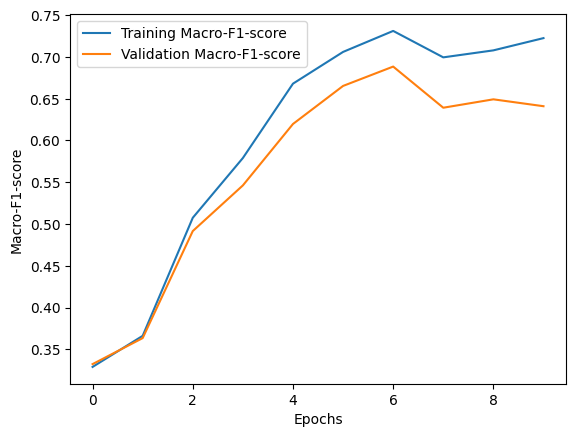

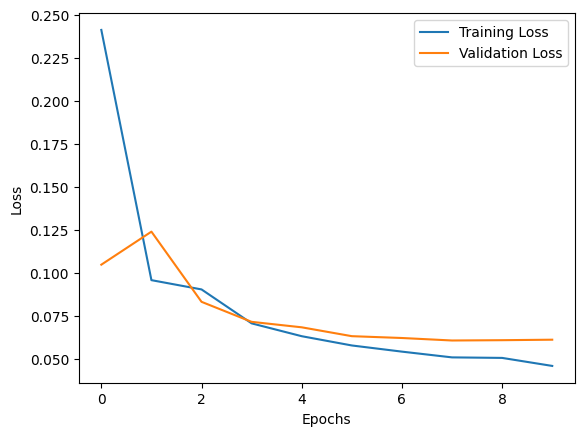

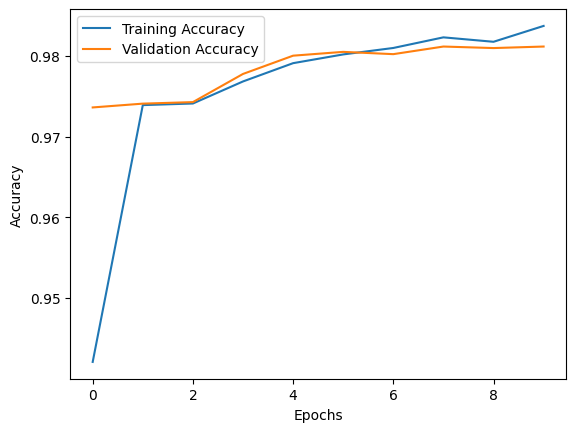

In [31]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.GRU(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()

In [32]:
model.save('GRU-Datset2-Glove.keras')

# LSTM

5/5 [==============================] - 0s 24ms/step
Epoch 1: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 1: Training Accuracy: 0.9615051746368408, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 27ms/step
Epoch 2: Training Macro-F1-score: 0.32887899034892354, Validation Macro-F1-score: 0.3288591672637529
Epoch 2: Training Accuracy: 0.9736263751983643, Validation Accuracy: 0.9735105633735657
5/5 [==============================] - 0s 24ms/step
Epoch 3: Training Macro-F1-score: 0.3945737843623316, Validation Macro-F1-score: 0.40222687777007043
Epoch 3: Training Accuracy: 0.9732100963592529, Validation Accuracy: 0.9743589758872986
5/5 [==============================] - 0s 24ms/step
Epoch 4: Training Macro-F1-score: 0.45447674350361056, Validation Macro-F1-score: 0.4648217240561095
Epoch 4: Training Accuracy: 0.9749583601951599, Validation Accuracy: 0.9770927429199219
5/5 [==============================]

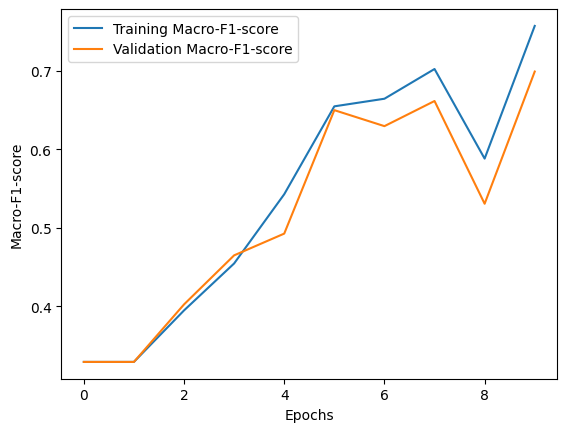

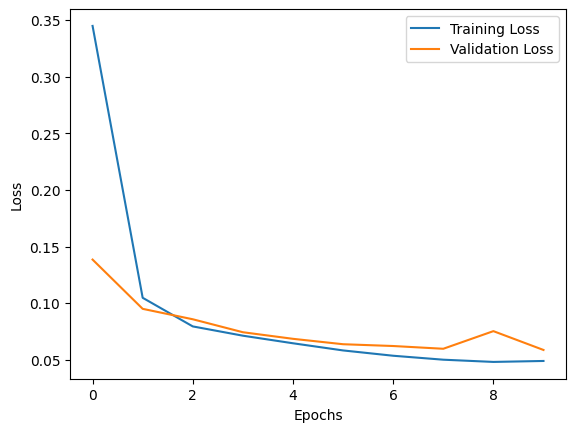

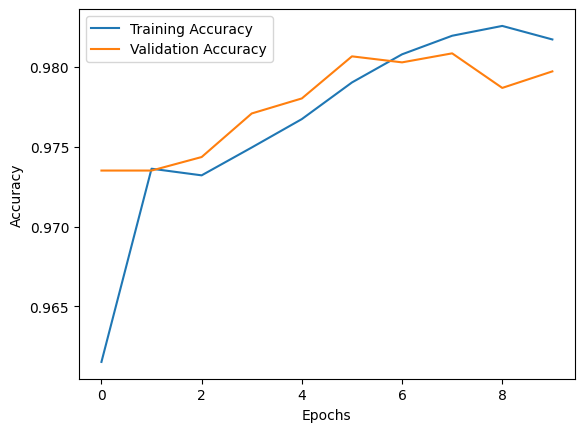

In [51]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

model = tf.keras.Sequential([
    tf.keras.layers.LSTM(units=128, return_sequences=True, input_shape=(78, 100)),
    tf.keras.layers.Dense(120, activation='relu'),
    tf.keras.layers.Dense(100, activation='tanh'),
    tf.keras.layers.Dense(3, activation='softmax')
])

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, verbose=1, restore_best_weights=True)

# Train the model and Initialize lists to store F1-score values
train_f1_scores = []
val_f1_scores = []
train_losses = []
val_losses = []
train_acc = []
val_acc = []

train_f1_scores_per_label = []
val_f1_scores_per_label = []

for epoch in range(10):
    # Perform one epoch of training
    history = model.fit(X_train, y_train, epochs=1, batch_size=32, verbose=True, validation_data=(X_val, y_val), callbacks=[early_stopping])

    # Get predictions for training and validation data
    y_train_pred = model.predict(X_train)
    y_val_pred = model.predict(X_val)

    # Convert one-hot encoded labels back to integer labels
    y_train_true = np.argmax(y_train, axis=-1)
    y_val_true = np.argmax(y_val, axis=-1)

    # Calculate F1-score for training and validation data
    train_f1 = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average='macro')
    val_f1 = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average='macro')

    train_f1_per_label = f1_score(y_train_true.flatten(), y_train_pred.argmax(axis=2).flatten(), average=None)
    val_f1_per_label = f1_score(y_val_true.flatten(), y_val_pred.argmax(axis=2).flatten(), average=None)
    
    # Append F1-score values to lists
    train_f1_scores_per_label.append(train_f1_per_label)
    val_f1_scores_per_label.append(val_f1_per_label)
    
    # Append F1-score values to lists
    train_f1_scores.append(train_f1)
    val_f1_scores.append(val_f1)

    # Append losses to lists
    train_losses.append(history.history['loss'])
    val_losses.append(history.history['val_loss'])

    # Append accuracy to lists
    train_acc.append(history.history['accuracy'])
    val_acc.append(history.history['val_accuracy'])

    # Print F1-score and accuracy for each epoch
    print(f'Epoch {epoch + 1}: Training Macro-F1-score: {train_f1}, Validation Macro-F1-score: {val_f1}')
    print(f'Epoch {epoch + 1}: Training Accuracy: {history.history["accuracy"][-1]}, Validation Accuracy: {history.history["val_accuracy"][-1]}')

# Plot F1-score
plt.plot(train_f1_scores, label='Training Macro-F1-score')
plt.plot(val_f1_scores, label='Validation Macro-F1-score')
plt.xlabel('Epochs')
plt.ylabel('Macro-F1-score')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_f1_score.png')  # Save F1-score figure
plt.show()

# Plot Loss
plt.plot(train_losses, label='Training Loss')
plt.plot(val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_loss.png')  # Save loss figure
plt.show()

# Plot Accuracy
plt.plot(train_acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
# plt.savefig('/home/seraj/ner/task_1_best_model/final_ner_model/task_1_Fasttext_simple_RNN_accuracy.png')  # Save accuracy figure
plt.show()

In [34]:
model.save('LSTM-Dataset2-Glove.keras')

In [13]:
# test data
def load_data(file):
    with open(file, 'r', encoding='utf-8') as f:
        data = json.load(f)
    return data
data2 = load_data("Dataset2-AspectTermExtraction_test.json")

texts2 = [i['text'] for i in data2]
labels = [i['labels'] for i in data2]
words2 = [sentence.split() for sentence in texts2]

max_length = max([len(i) for i in words2])
max_length

71

In [14]:
def load_glove_embeddings(glove_file, embedding_dim):
    """Loads pre-trained GloVe word embeddings from a file.
    Returns: dict: A dictionary mapping words to their corresponding embedding vectors.
             np.ndarray: An embedding matrix with rows representing words and columns representing dimensions.
    """
    embeddings_index = {}
    embedding_matrix = np.zeros((len(word_to_id) + 1, embedding_dim))  # Add 1 for padding

    with open(glove_file, encoding='utf-8') as f:
        for line in f:
            values = line.split()
            word = values[0]
            coefs = np.asarray(values[1:], dtype='float32')
            embeddings_index[word] = coefs

    for word, index in word_to_id.items():
        embedding_vector = embeddings_index.get(word)
        if embedding_vector is not None:
            embedding_matrix[index] = embedding_vector
        else:
            embedding_matrix[index] = np.zeros(embedding_dim)

    return embeddings_index, embedding_matrix

# Replace with your downloaded GloVe file path and desired dimensionality
glove_file = "glove.6B.100d.txt"  # Example: glove.6B.100d.txt
embedding_dim = 100

# Create a dictionary mapping words to their unique IDs (optional for vectorization)
word_to_id = {}
next_id = 1
for sentence in words2:  # Iterate through sentences in the nested list
    for word in sentence:
        if word not in word_to_id:
            word_to_id[word] = next_id
            next_id += 1

# Load the GloVe embeddings
embeddings_index, embedding_matrix = load_glove_embeddings(glove_file, embedding_dim)

# Vectorization of words
word_embeddings2 = []
for sentence in words2:
    sentence_embedding = []
    for word in sentence:
        vector = embeddings_index.get(word)
        if vector is not None:
            sentence_embedding.append(vector)
        else:
            sentence_embedding.append(np.zeros(100)) # dimension of the glove file used.
    word_embeddings2.append(sentence_embedding)

for sentence in word_embeddings2:
    sentence_length = len(sentence)
    if sentence_length < 78: #max length of sentence = 78
        while len(sentence) < 78:
            sentence.append(np.zeros(100))     

# padding to convert into (905, 70, 100)  from (905, variable_length, 70)           
for i in range(len(word_embeddings2)):
    word_embeddings2[i] = np.array(word_embeddings2[i])
word_embeddings2 = np.array(word_embeddings2)
print(word_embeddings2.shape) 


(328, 78, 100)


In [15]:
flat_labels = [label for sublist in labels for label in sublist]

# Find unique labels
unique_labels = set(flat_labels)

print(unique_labels)

# label2idx = {label: idx for idx, label in enumerate(unique_labels)}
labels2idx = {'B': 0, 'I': 2, 'O': 1}
labels_idx = [[label2idx[label] for label in sublist] for sublist in labels]


# One-hot encode labels
num_classes = len(unique_labels)
one_hot_labels = [to_categorical(sublist, num_classes=num_classes) for sublist in labels_idx]

def convert_to_list(lst):
    if isinstance(lst, np.ndarray):
        return lst.tolist()
    elif isinstance(lst, list):
        return [convert_to_list(item) for item in lst]
    else:
        return lst
one_hot_labels = convert_to_list(one_hot_labels)
labels_idx[0]

{'O', 'B', 'I'}


[1, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]

In [16]:
for sentence in one_hot_labels:
    sentence_length = len(sentence)
    if sentence_length < 78: #max length of sentence = 78
        while len(sentence) < 78:
            sentence.append([0., 1., 0.])

one_hot_labels = np.array(one_hot_labels)
one_hot_labels.shape

(328, 78, 3)

In [17]:
word_embeddings2.shape

(328, 78, 100)

In [18]:
#LSTM model
X_test_padded = word_embeddings2
y_test_padded = one_hot_labels

model = tf.keras.models.load_model('SimpleRNN-Dataset2-Glove.keras')
# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test_padded, y_test_padded)
print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)



11/11 [==============================] - 2s 20ms/step - loss: 1.1114 - accuracy: 0.8125
Test Loss: 1.1114071607589722
Test Accuracy: 0.8125391006469727


In [19]:
unique_labels = set(labels2idx.keys())

In [20]:
from sklearn.metrics import classification_report
y_pred = model.predict(X_test_padded)
# Assuming y_pred contains continuous values, convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_test_classes = np.argmax(y_test_padded, axis=2).flatten()
target_names = [str(label) for label in unique_labels]
# target_names = [str(label) for label in range(27)]  # Assuming you have 27 unique labels
# Generate the classification report using true target values and predicted target values
report = classification_report(y_test_classes, y_pred_classes, target_names=target_names)
print(report)

11/11 [==============================] - 1s 19ms/step
              precision    recall  f1-score   support

           O       0.09      0.00      0.01      4465
           B       0.82      0.99      0.90     20876
           I       0.84      0.29      0.43       243

    accuracy                           0.81     25584
   macro avg       0.58      0.43      0.44     25584
weighted avg       0.69      0.81      0.74     25584



In [86]:
import tensorflow as tf

modelG = tf.keras.models.load_model('GRU-Datset2-Glove.keras')
modelL = tf.keras.models.load_model('LSTM-Dataset2-Glove.keras')

from sklearn.metrics import classification_report
y_pred = modelG.predict(X_test_padded)
# Assuming y_pred contains continuous values, convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_test_classes = np.argmax(y_test_padded, axis=2).flatten()
target_names = [str(label) for label in unique_labels]
# target_names = [str(label) for label in range(27)]  # Assuming you have 27 unique labels
# Generate the classification report using true target values and predicted target values
report = classification_report(y_test_classes, y_pred_classes, target_names=target_names)
print("GRU",report)

from sklearn.metrics import classification_report
y_pred = modelL.predict(X_test_padded)
# Assuming y_pred contains continuous values, convert them to class labels
y_pred_classes = np.argmax(y_pred, axis=2).flatten()
y_test_classes = np.argmax(y_test_padded, axis=2).flatten()
target_names = [str(label) for label in unique_labels]
# target_names = [str(label) for label in range(27)]  # Assuming you have 27 unique labels
# Generate the classification report using true target values and predicted target values
report = classification_report(y_test_classes, y_pred_classes, target_names=target_names)
print("LSTM",report)

# test_loss, test_accuracy = modelG.evaluate(X_test_padded, y_test_padded)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

# test_loss, test_accuracy = modelS.evaluate(X_test_padded, y_test_padded)
# print("Test Loss:", test_loss)
# print("Test Accuracy:", test_accuracy)

11/11 [==============================] - 1s 19ms/step - loss: 0.0556 - accuracy: 0.9807
Test Loss: 0.05558900162577629
Test Accuracy: 0.9806910753250122


In [ ]:
from sklearn.metrics import classification_report

y_pred = model.predict(X_test_padded)

y_true = [label.argmax() for label in y_test_padded]
y_pred = [prediction.argmax() for prediction in y_pred]

report = classification_report(y_true, y_pred)
print(report)
